# Process Awkward Arrays to Using NN
---
This notebook shows the process of coming from awkward arrays to a format that can be used by the neural network.<br>
The network is a simple fully connected network with 3 hidden layers and 1 output layer.<br>
The task is to classify the events into either accepted or rejected dependent on the paramterized input of signal regions.<br>

### Import Modules

In [1]:
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import EarlyStopping
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


# own modules
from utils.models import MLP_classifier
from utils.data import (DatasetMLP, get_array_from_pMSSM_point,
                        from_df_2_df, sr_acc_rej, 
                        sample_events_signal_regions, parameterize_df_with_sel_events)

from utils.plots import plot_distribution_of_events, plot_loss_curve


# no warnings
pd.options.mode.chained_assignment = None  # default='warn'

/Users/leonrenn/opt/miniconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/leonrenn/opt/miniconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <BB67D2A7-5160-3C5A-AC1A-029AEC0F181F> /Users/leonrenn/opt/miniconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <89B80E63-0720-39CB-96E3-B331A14BC5A2> /Users/leonrenn/opt/miniconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load pMSSM Point
The pMSSM point is loaded from a ROOT file.<br>
Within the function the awkward array is converted to a pandas dataframe which itself contains awkward arrays.

In [2]:
# awkward array from pMSSM point in dataframe format
df = get_array_from_pMSSM_point("data/100293.root")

### Process Awkward Arrays to Pandas Dataframe

Even though the dataframe is in the pandas dataframe format it needs to be reprocessed again because internally there are still awkward arrays.<br>
Fields that are not needed for the NN are dropped.<br>
Moreover the data needs to be normalized in order to be used by the NN successfully.<br>

In [3]:
df, norm_factor = from_df_2_df(df=df, 
                               remove_fields=["Event", 
                                              "eventWeight",
                                              "mcWeights"],
                               normalize=True)

### Load all Possible Signal Regions with Acceptance and Rejection
Load signal regions from SA data and the corresponding events (rejected or accteped).

In [4]:
df_acc_rej = sr_acc_rej(path_data="data/100293/",
                        path_info="pMSSMFactory-master-Analyses/Analyses/")

### Plot Distribution of Accepted Events
Only the signal regions above a certain threshold are accpeted for the further analysis.

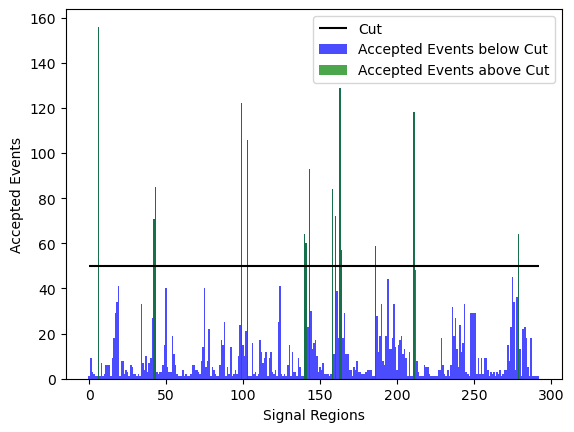

In [5]:
plot_distribution_of_events(df_acc_rej=df_acc_rej,
                            hline_y=50)

### Sample Events from Accepted and Rejected Events Equally

In [6]:
sample_indices = sample_events_signal_regions(df_acc_rej=df_acc_rej,
                                              cut_acc_events=50)

### Parameterize the Selected Events

In [7]:
df_complete, srs_values = parameterize_df_with_sel_events(df=df, 
                                sample_indices=sample_indices)

/Users/leonrenn/Documents/Programming/Python/Projects/AWKWARD-TO-GNN/utils/data.py:299: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["signal_region"] = 0.0
/Users/leonrenn/Documents/Programming/Python/Projects/AWKWARD-TO-GNN/utils/data.py:300: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["accepted"] = 0


### Perpare Data for Training


In [8]:
# initialize the dataset and the dataloader
# complete dataset
dataset = DatasetMLP(df_complete=df_complete)

# split dataset into train and val
train_size = int(0.8 * len(dataset))
val_size = int((len(dataset) - train_size)/2)
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_set = random_split(dataset = dataset,
                                                    lengths=[train_size, val_size, test_size], 
                                                    generator=torch.Generator().manual_seed(42))

# initialize dataloader
train_dataloader = DataLoader(dataset=train_dataset, 
                        batch_size=8, 
                        shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                        batch_size=8,
                        shuffle=False)
test_dataloader = DataLoader(dataset=test_set,
                        batch_size=8,
                        shuffle=False)

/Users/leonrenn/Documents/Programming/Python/Projects/AWKWARD-TO-GNN/utils/data.py:334: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df_complete[col + str(i)] = (self.df_complete[col]
/Users/leonrenn/Documents/Programming/Python/Projects/AWKWARD-TO-GNN/utils/data.py:334: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df_complete[col + str(i)] = (self.df_complete[col]
/Users/leonrenn/Documents/Programming/Python/Projects/AWKWARD-TO-GNN/utils/data.py:334: PerformanceWarning: DataFrame is highly fragmented.  This is usual

### Train the Model
Start the training of the model. Even though the data is small lets see how good the model learns based on one pMSSM point.

In [9]:
# initialize the dimensions
input_dim = dataset[0][0].shape[1]
output_dim = 1
hidden_dim = 10

# initialize the model
model = MLP_classifier(input_dim=input_dim,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        output_method="classifier")

# initialize the trainer
trainer = pl.Trainer(max_epochs=2,
                    enable_progress_bar=True,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, mode='min')])
trainer.fit(model, 
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

# save the model
torch.save(model.state_dict(), 
           "trained_models/model.pt")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params
---------------------------------------------
0 | model     | Sequential     | 5.8 K 
1 | train_acc | BinaryAccuracy | 0     
2 | val_acc   | BinaryAccuracy | 0     
3 | test_acc  | BinaryAccuracy | 0     
---------------------------------------------
5.8 K     Trainable params
0         Non-trainable params
5.8 K     Total params
0.023     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/leonrenn/opt/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/leonrenn/opt/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


### Test the Model

In [10]:
trainer.test(model,
             dataloaders=test_dataloader)

/Users/leonrenn/opt/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9673330783843994
        test_loss           0.13129748404026031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.13129748404026031, 'test_acc': 0.9673330783843994}]

### Visualize the Training Curve

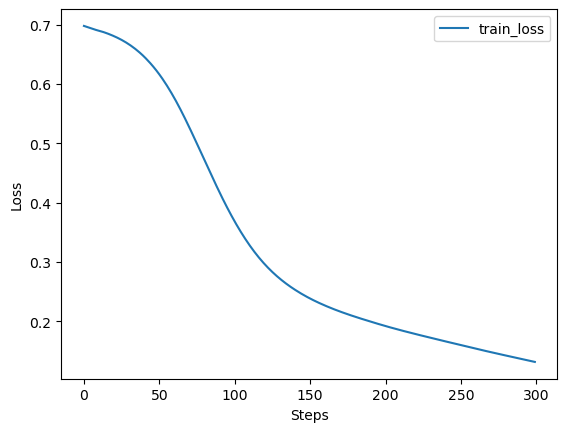

In [11]:
plot_loss_curve(model=model)